## Imports

In [4]:
import numpy as np
import math
import datascience
import scipy
from datascience import *
from scipy import *
from scipy.signal import find_peaks, find_peaks_cwt, savgol_filter
import sklearn
from sklearn.metrics import mean_absolute_error
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plots
plots.rcParams["figure.figsize"] = (10,7)
import time

## Data
`Peak_Interval_List.csv` and `Ig110postbakemap9476.CSV` from
Graphite Raman Mapping (Project 31) on Box.

x,y
500,1.11038
500.137,0.985766
500.274,0.951698
500.411,0.957243
500.547,0.893833
500.684,0.883336
500.821,0.872838
500.958,0.889714
501.095,0.849866
501.232,0.835878


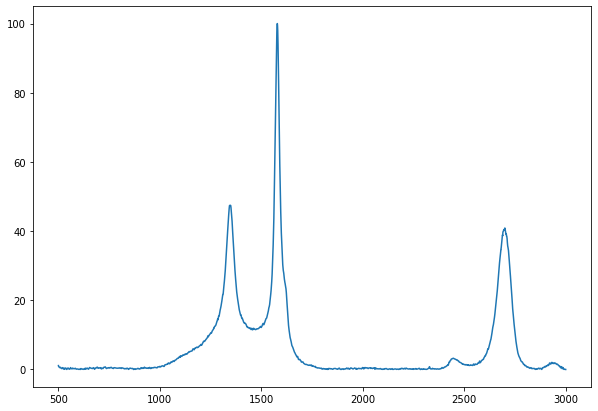

In [5]:
peak_intervals = Table().read_table("new_peak_list.csv")
sample_spectrum = Table().read_table("JQ2a2_16.csv")
plots.plot(sample_spectrum.column("x"), sample_spectrum.column("y"))
sample_spectrum

In [6]:
peak_intervals

Peak Name,Peak Number,Optional?,Min Bound X,Max Bound X
Pre-D,1,Yes,1000,1320
D,2,No,1340,1360
D-G shoulder,3,Yes,1370,1550
G,4,No,1560,1600
D' shoulder,5,No,1600,1630
T+D,6,Yes,2300,2500
G'_3Da,7,No,2640,2690
G'_2D,8,No,2680,2720
G'_3DB,9,No,2700,2740
D'+D,10,No,2850,2950


## Driver Function
`spectrum`: table with two columns: x and y <br>  
`num_peaks`: int, how many peaks to fit with <br>  
`baseline_deg`: degree of polynomial to fit baseline with  <br>  
`baseline_tol`: tolerance to stop baseline iteration  <br>  
`peak_type`: lorentz/gaussian, later add option to choose others (examples in the matlab, should be able to express with the same parameters) <br>  
`error`: MAE, MSE, etc. <br>  
`tolerance`: to within what error should we fit <br>  
`num_iterations`: how many iterations should we go through <br>  
`window_len`: length of savitsky-golay filter window <br>  
`polyorder`: order of polynomial to fit samples in savitsky-golay

In [7]:
lambda_1 = 0.05
lambda_2 = 0.05

In [ ]:
def fit_spectrum(spectrum, num_peaks, baseline_deg, baseline_tol, peak_type, error_type, tolerance, num_iterations, window_len, polyorder):
    start_time = time.time() # unit: seconds
    # Restrict data x to 500-3000
    restricted_spectrum = spectrum.where("x", are.between_or_equal_to(500, min(3000, max(spectrum.column("x")))))
    # Smooth signal with Savitsky-Golay filter
    smoothed_y = scipy.signal.savgol_filter(restricted_spectrum.column("y"), window_len, polyorder)
    smoothed_spectrum = Table().with_columns("x", restricted_spectrum.column("x"), "y", smoothed_y)
    # Remove baseline
    spectrum_baseline_removed = remove_baseline(smoothed_spectrum, baseline_deg, baseline_tol)
    # Normalize spectrum
    normalized_y = ((spectrum_baseline_removed.column("y") - min(spectrum_baseline_removed.column("y")))
                    / (max(spectrum_baseline_removed.column("y")) - min(spectrum_baseline_removed.column("y"))))
    normalized_spectrum = Table().with_columns("x", spectrum_baseline_removed.column("x"), "y", normalized_y)
    # Identify peaks
    # check peak interval - edit num_peaks
    detected_peaks = detect_peaks(normalized_spectrum, num_peaks)
    # Reconstruct spectra
    peaks = create_peaks(peak_type, detected_peaks)

    # Create loss function that we will optimize
    def error(guess_array):
        # first num_peaks elems are amp, next are cen, next are wid
        amp = guess_array[0:num_peaks]
        cen = guess_array[num_peaks:2*num_peaks]
        wid = guess_array[2*num_peaks:3*num_peaks]
        guess_peaks = Table().with_columns("Peak #", range(num_peaks),
                                          "amp", amp, "cen", cen, "wid", wid)
        reconstructed = reconstruct_spectrum(normalized_spectrum, guess_peaks)
        # choose error
        if error_type == "MAE":
            e = sklearn.metrics.mean_absolute_error(normalized_spectrum.column("y"), reconstructed)
        elif error_type == "MSE":
            e = sklearn.metrics.mean_squared_error(normalized_spectrum.column("y"), reconstructed)
        elif error_type == "MAPE":
            e = sklearn.metrics.mean_absolute_percentage_error(normalized_spectrum.column("y"), reconstructed)
        elif error_type == "RMSPE":
            e = RMSPE(normalized_spectrum.column("y"), reconstructed)
        else:
            raise Exception("Error type not supported")
        print(e)
        #return e
        return e + lambda_1 * (1 if guess_array[num_peaks + 8] < guess_array[num_peaks + 7] else 0) + lambda_2 * abs(guess_array[6] / guess_array[8] - 0.5)
    
    # change this from numpy appending to normal python list operations
    initial_guess = np.append(np.append(peaks.column("amp"), peaks.column("cen").astype(int)), peaks.column("wid"))

    # create bounds
    amp_bounds = [(0.0001, 300) for i in range(num_peaks)]
    min_x = peak_intervals.column("Min Bound X")
    max_x = peak_intervals.column("Max Bound X")
    cen_bounds = [(min_x[i], max_x[i]) for i in range(num_peaks)]
    wid_bounds = [(0.0001, 400) for i in range(num_peaks)]
    bounds = amp_bounds + cen_bounds + wid_bounds
    
    amp_lower = [0.0001 for i in range(num_peaks)]
    amp_upper = [300 for i in range(num_peaks)]
    cen_lower = [min_x[i] for i in range(num_peaks)]
    cen_upper = [max_x[i] for i in range(num_peaks)]
    wid_lower = [0.0001 for i in range(num_peaks)]
    wid_upper = [400 for i in range(num_peaks)]
    lower_bounds = amp_lower + cen_lower + wid_lower
    upper_bounds = amp_upper + cen_upper + wid_upper
    ls_bounds = (lower_bounds, upper_bounds)
    
    # ensure center of peak 9 > peak 8
    cons1 = {"type": "ineq", "fun": lambda arr: arr[num_peaks + 8] - arr[num_peaks + 7]}
    # upper bound for peak 7 : peak 9 (amplitude)
    cons2 = {"type": "ineq", "fun": lambda arr: arr[6] / arr[8] - 0.45}
    # lower bound for peak 7 : peak 9 (amplitude)
    cons3 = {"type": "ineq", "fun": lambda arr: -(arr[6] / arr[8]) + 0.55}
    constraints = [cons1, cons2, cons3]
    constraints_test = [cons1]
    
    # original minimize call - commenting out for testing others
    #result = scipy.optimize.minimize(error, initial_guess, bounds=bounds, tol=tolerance,
    #                                 options={"maxiter": num_iterations}, constraints=constraints_test).x
    
    # trust-const implementation
    #result = scipy.optimize.minimize(error, initial_guess, bounds=bounds, tol=None,
    #                                options={"maxiter": num_iterations, "verbose": 2}, constraints=constraints_test,
    #                                method = "trust-constr")
    
    # nelder-mead implementation
    #result = scipy.optimize.minimize(error, initial_guess, bounds=bounds, tol=None,
    #                                 options={"maxiter": num_iterations},
    #                                    method = "Nelder-Mead")
    result = scipy.optimize.least_squares(error, initial_guess, bounds=ls_bounds, verbose=2)
    
    #print("Status: ", result.status)
    #print("Execution time: ", result.execution_time)
    #print("Solution:", result.x)
    #print("Message: ", result.message)
    print("Cost: ", result.cost)
    print("Numiters: ", result.nfev)
    print("Message: ", result.message)
    final_error = error(result.x)
    
    result = result.x
    
    # plot result
    result_matrix = Table().with_columns("Peak #", np.arange(num_peaks),
                                        "amp", result[0:num_peaks],
                                        "cen", result[num_peaks:2*num_peaks],
                                        "wid", result[2*num_peaks:3*num_peaks])
    print(result_matrix)
    reconstructed_y = reconstruct_spectrum(normalized_spectrum, result_matrix)
    
    guess_and_real = Table().with_columns("Real", normalized_y, "Reconstructed", reconstructed_y, "x", normalized_spectrum.column("x"))
    # guess_and_real.plot("x")
    
    
    # Temporary test code
    # Plotting individual peaks
    test_plot = guess_and_real
    for i in range(num_peaks):
        parameters_i = result_matrix.row(i)
        amp_i = parameters_i.item("amp")
        cen_i = parameters_i.item("cen")
        wid_i = parameters_i.item("wid")
        peak_i = [lorentz(x, amp_i, cen_i, wid_i) for x in normalized_spectrum.column("x")]
        test_plot = test_plot.with_columns(f"Peak {i}", peak_i)
    # test_plot.plot("x")
    plots.plot(test_plot.column("x"), test_plot.column("Real"), label="Real")
    plots.plot(test_plot.column("x"), test_plot.column("Reconstructed"), label="Reconstructed")
    for i in range(num_peaks):
        plots.plot(test_plot.column("x"), test_plot.column(f"Peak {i}"), label=f"Peak {i}")
    plots.legend()
    
    
    
    end_time = time.time()
    print(f"Program runtime (minutes):  {(end_time - start_time) / 60}")
    return (result, final_error)

In [9]:
# returns an array the same length as x
# fits points in spectrum x to polynomial of degree deg
# change tol to be for error between previous line and new line

# save old coeffs to compare polynomials on the same set of x values -> above/below tol
# try a value for tol - set a default
# doesn't really matter which error we use - use msre with a tolerance of 1% (or MRE)
# initial guess: fit line
# full=True allows us to access sum of squared residuals of the fit as well
def baseline(spectrum, deg, tol):
    s = spectrum
    e = float('inf')
    old_coef = None
    nrows = 0
    while(e > tol):
        # adding this condition to hopefully make stuff better
        if spectrum.num_rows == 0:
            break;
        print(e)
        # create fit line w/ np.polyfit & turn into a function w/ polyn
        coef = np.polyfit(spectrum.column("x"), spectrum.column("y"), deg, full=False)
        polyn = make_polynomial(coef, deg)
        # re-fit line to remaining points
        
        baseline_fit = spectrum.apply(polyn, "x")
        #plots.plot(spectrum.column("x"), spectrum.column("y"))
        
        #plots.plot(spectrum.column("x"), baseline_fit)
        # do error b/t previous line
        if type(old_coef) != type(None):
            #e = sklearn.metrics.mean_absolute_error(baseline_fit, spectrum.apply(make_polynomial(old_coef, deg), "y"))
            e = RMSPE(baseline_fit, spectrum.apply(make_polynomial(old_coef, deg), "x"))
        # remove any points above fit line
        spectrum = spectrum.with_column("baseline", baseline_fit)
        print(spectrum)
        wanted_indices_bool = spectrum.column("y") <= spectrum.column("baseline")
        wanted_indices = [i for i in range(len(wanted_indices_bool)) if wanted_indices_bool[i]]
        spectrum = spectrum.take(wanted_indices)
        # repeat until fitting error < tol or # points doesn't change
        old_coef = coef
        print("spectrum rows ", spectrum.num_rows)
        print("nrows ", nrows)
        if spectrum.num_rows == nrows:
            print("nrows exit")
            break
        nrows = spectrum.num_rows
    # changed spectrum
    baseline_ret = s.apply(polyn, "x")
    #plots.plot(s.column("x"), s.column("y"))
    #plots.plot(s.column("x"), baseline_ret)
    return baseline_ret

In [10]:
# takes in a table and returns a table w/ same columns & dimensions
def remove_baseline(spectrum, deg, tol):
    bl = baseline(spectrum, deg, tol)
    return Table().with_columns("x", spectrum.column("x"), "y", spectrum.column("y") - bl)

In [11]:
# returns a single-variable polynomial function of degree deg from coefficients coef
def make_polynomial(coef, deg):
    # takes in an array of x values and returns an array of y values of the same dimension
    def polyn(x):
        y = 0
        for i in range(deg + 1):
            y += pow(x, deg - i) * coef[i]
        return y
    return polyn

In [12]:
# returns an array with num_peaks x-values set to the midpoint of their bounds
# add option to remove peaks that are not required for lower num_peaks
def detect_peaks(spectra, num_peaks):
    midpoints = (peak_intervals.column("Min Bound X") + peak_intervals.column("Max Bound X")) / 2
    return midpoints

In [13]:
# returns a matrix of initial guesses
# dimensions 4 x num_peaks (4 = num parameters - x)
def create_peaks(peak_type, detected_peaks):
    if peak_type == "lorentz":
        parameter_matrix = Table(["Peak #", "amp", "cen", "wid"])
        for i in np.arange(len(detected_peaks)):
            amp = guess_amp()
            cen = detected_peaks[i]
            wid = guess_wid()
            parameter_matrix.append([i, amp, cen, wid])
        return parameter_matrix
    elif peak_type == "gaussian":
        return False

In [14]:
def guess_amp():
    return 5

In [15]:
def guess_wid():
    return 10

In [16]:
# x - values where the function is calculated
# y_0 - baseline
# amp - area
# cen - peak's center position
# wid - controls full width half maximum of the function
def lorentz(x, amp, cen, wid):
    return (amp/np.pi)*(wid / ((x - cen) ** 2 + wid ** 2))

In [17]:
# x - values where the function is calculated
# y_0 - baseline
# height - height of peak
# center - center of peak
# std - standard deviation
def gaussian(x, y_0, amp, cen, wid):
    std=wid/2.355
    return (amp / (std * np.sqrt(2*np.pi))) * (np.e ** -(((x - center) ** 2)) / 2 * std ** 2) + y_0

In [18]:
# returns an array of y values for each x value in spectrum. y values obtained using peak_parameters
def reconstruct_spectrum(spectrum, peak_parameters):
    def reconstruct_sum(x):
        peaks = peak_parameters.with_columns("x", [x for i in range(peak_parameters.num_rows)])
        sum_peaks = peaks.apply(lorentz, "x", "amp", "cen", "wid")
        return np.sum(sum_peaks)
    reconstructed = [reconstruct_sum(x) for x in spectrum.column("x")]
    return reconstructed

In [27]:
def RMSPE(y_true, y_pred):
    EPSILON = 1e-10
    return np.sqrt(np.mean(np.square((y_true + EPSILON - y_pred) / (y_true + EPSILON)))) * 100

## Demo

fit_spectrum(spectrum, num_peaks, baseline_deg, baseline_tol, peak_type, error_type, tolerance, num_iterations, window_len, polyorder)

inf
x       | y        | baseline
500     | 1.05406  | 6.02184
500.137 | 1.01698  | 6.02186
500.274 | 0.982849 | 6.02189
500.411 | 0.951655 | 6.02191
500.547 | 0.923403 | 6.02193
500.684 | 0.898092 | 6.02195
500.821 | 0.875722 | 6.02198
500.958 | 0.856294 | 6.022
501.095 | 0.849612 | 6.02202
501.232 | 0.838061 | 6.02204
... (18261 rows omitted)
spectrum rows  13742
nrows  0
inf
x       | y        | baseline
500     | 1.05406  | 0.823646
500.137 | 1.01698  | 0.823664
500.274 | 0.982849 | 0.823683
500.411 | 0.951655 | 0.823701
500.547 | 0.923403 | 0.82372
500.684 | 0.898092 | 0.823738
500.821 | 0.875722 | 0.823757
500.958 | 0.856294 | 0.823775
501.095 | 0.849612 | 0.823794
501.232 | 0.838061 | 0.823812
... (13732 rows omitted)
spectrum rows  9605
nrows  13742
534.726958055013
x       | y        | baseline
501.505 | 0.818901 | 0.316991
501.642 | 0.807879 | 0.316989
501.779 | 0.795999 | 0.316987
501.916 | 0.783613 | 0.316986
502.053 | 0.772772 | 0.316984
502.189 | 0.758631 | 0.316982
502.3

1088098.484254658
1088098.4873389197
1088098.5021895159
1088098.5111015388
1088098.5110030526
1088098.511049395
1088098.5112153576
1088098.5112984104
1088098.5154234967
1088098.5127628497
1088098.5124376821
1088098.5122660457
1088098.511285562
       3              4         5.9198e+11      2.44e+12       6.62e+01       3.70e+11    
661690.7374254097
661690.7382897636
661690.7380793913
661690.7381015576
661690.7382115194
661690.7382692586
661690.7404060159
661690.7390915873
661690.7389399995
661690.7388507619
661690.738219373
661690.7349777443
661690.7376756282
661690.7382440808
661690.7396402162
661690.7402806538
661690.7191542323
661690.7150784192
661690.718455172
661690.7202662794
661690.7304434974
661690.738289637
661690.7380793517
661690.7381015166
661690.7382114608
661690.7382691887
661690.7380605497
661690.7390912025
661690.7389396904
661690.738850492
661690.7382192964
       4              5         2.1892e+11      3.73e+11       1.86e+00       7.40e+10    
447360.70609192527
4

11865.934315354334
11865.934432228583
11865.9344083696
11865.934415195754
11865.934416483355
11865.934421325019
11865.935125179372
11865.9345226763
11865.93449736515
11865.934483842319
11865.93440830293
11865.93424556819
11865.934305046834
11865.934366520369
11865.9343691078
11865.934379850507
11865.934313350363
11865.934227015405
11865.934199968617
11865.934184088528
11865.934108260059
11865.934340562939
11865.934342799554
11865.93434032139
11865.934339779982
11865.934338615321
11865.934315435314
11865.934322087713
11865.934324741525
11865.934326464061
11865.93433955316
      16             17         7.0400e+07      3.07e+07       1.31e-01       2.19e+07    
9986.23287141931
9986.232986142424
9986.232962358274
9986.232968899536
9986.232970190016
9986.232974946353
9986.233677859645
9986.23307641083
9986.233050891538
9986.233037272457
9986.23296197528
9986.23281242555
9986.232861970224
9986.232914802918
9986.232916969717
9986.23292584285
9986.232869423893
9986.23280627157
9986.23278306

99.99192377815181
99.99192378526864
99.9919236818561
99.99192379609818
99.99192381943081
99.99192358316918
99.99192378770857
99.99192379694556
99.9919237915642
99.99192386362141
99.99192355289888
99.99192379695067
99.99192379708973
99.99192379713186
99.99192379716338
99.991923797411
99.99192379742581
99.99192379710017
99.99192379711526
99.99192379713013
99.99192379649014
      28             29         4.9992e+03      2.29e+01       2.34e+00       3.79e+04    
12528.77748779246
1094.8935316911968
184.24368100804404
104.27445899161523
100.19539966765774
99.99731710083152
99.99057943245742
99.99057943560054
99.9905794348651
99.99057944044752
99.9905794414489
99.99057943765267
99.99057951471393
99.9905794765215
99.99057946754087
99.9905794605543
99.99057942783806
99.99057941982282
99.99057930801428
99.99057943159475
99.99057945492828
99.99057919659126
99.99057942302227
99.99057943237537
99.99057942699379
99.99057949905126
99.99057914953934
99.99057943262237
99.99057943285223
99.9905794328

(array([1.29869330e-03, 1.77097546e-03, 1.23983133e-03, 1.17651611e-03,
        1.10456250e-03, 1.00000000e-04, 1.56493828e-04, 2.07128550e-04,
        2.52258695e-04, 3.29997952e-03, 1.31999996e+03, 1.34331198e+03,
        1.54919325e+03, 1.56340245e+03, 1.62985128e+03, 2.49999971e+03,
        2.68999734e+03, 2.71983998e+03, 2.73976443e+03, 2.90401423e+03,
        2.70358113e-02, 2.46090578e-02, 2.39217182e-02, 2.39521754e-02,
        2.32287290e-02, 2.91553879e-02, 3.13832239e-02, 2.91250278e-02,
        2.79319245e-02, 2.64712187e-02]),
 99.99048717706421)

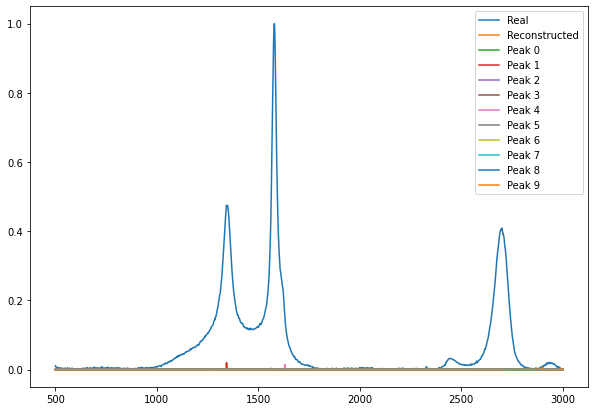

In [28]:
fit_spectrum(sample_spectrum, 10, 1, 0.01, "lorentz", "RMSPE", None, 1000, 15, 2)